In [1]:
import torch
import matplotlib.pyplot as plt

import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
words = open('../shared/data/names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
from shared.utils import build_char_index_maps


stoi, itos = build_char_index_maps(words)

# Define block size and build dataset

In [4]:
block_size = 3 # context length

In [5]:
'''
builds something like:
emma:
    ... -> e
    ..e -> m
    .em -> m
    emm -> a
    mma -> .
'''
def build_dataset(words: list[str], print_count=0):
    X, Y = [], []
    print_sizes = print_count > 0
    for word in words:
        if print_count > 0:
            print(word)
        
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]

            X.append(context)
            Y.append(ix)

            if print_count > 0:
                print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] # crop and append

        if print_count:
            print_count -= 1
            print()
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    if print_sizes:
        print("X", X.shape)
        print("Y", Y.shape)

    return X, Y

In [6]:
X, Y = build_dataset(words, print_count=2)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

X torch.Size([228146, 3])
Y torch.Size([228146])


In [7]:
from mlp import *

g = torch.Generator().manual_seed(0)
mlp = MLP(generator=g)

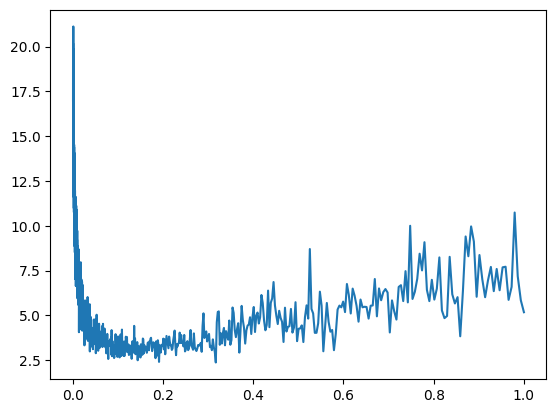

In [8]:
# To find a good learning rate, we could do the following:
learning_rate_exponents = torch.linspace(-3, 0, steps=1000)
learning_rates = 10 ** learning_rate_exponents

learning_rate_i = []
loss_i = []
for i in range(1000):
    loss = mlp.train(X, Y, epochs=1, learning_rate=learning_rates[i], print_losses=False)
    learning_rate_i.append(learning_rates[i])
    loss_i.append(loss.item())

plt.plot(learning_rate_i, loss_i)

In [9]:
g = torch.Generator().manual_seed(0)
mlp = MLP(generator=g)

loss = mlp.train(X, Y, epochs=10000, learning_rate=0.1, print_losses=False)
loss

tensor(2.1853, grad_fn=<NllLossBackward0>)

Can do learning rate decay when the loss plateaus. Meaning go from 0.1 to 0.001.

# Dataset splitting

As we add more neurons, the nn becomes more and more capable of overfitting the training set. So the loss on the training set can get very small, but when sampling from it we don't get new data and the loss on some new data will be high.  
  
To address this we split the data in 3 parts:  
    - training set: optimize the params of the model using gradient descent - 80%  
    - dev/validation set: development of hyperparameters of the model (size of hidden layer, size of embedding, strength of regularization, etc.) - 10%  
    - test set: evaluate the performance of the model - 10%  

In [10]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [11]:
g = torch.Generator().manual_seed(0)

mlp = MLP(generator=g)

In [12]:
mlp.train(Xtr, Ytr, 10000, learning_rate=0.1, print_losses=False)

tensor(2.6332, grad_fn=<NllLossBackward0>)

In [13]:
mlp.forward(Xdev, Ydev)

tensor(2.4378, grad_fn=<NllLossBackward0>)

# Visualize dimensions 0 and 1 of the embedding matrix C for all characters
We can see that for example are close together and . is not close to the other character

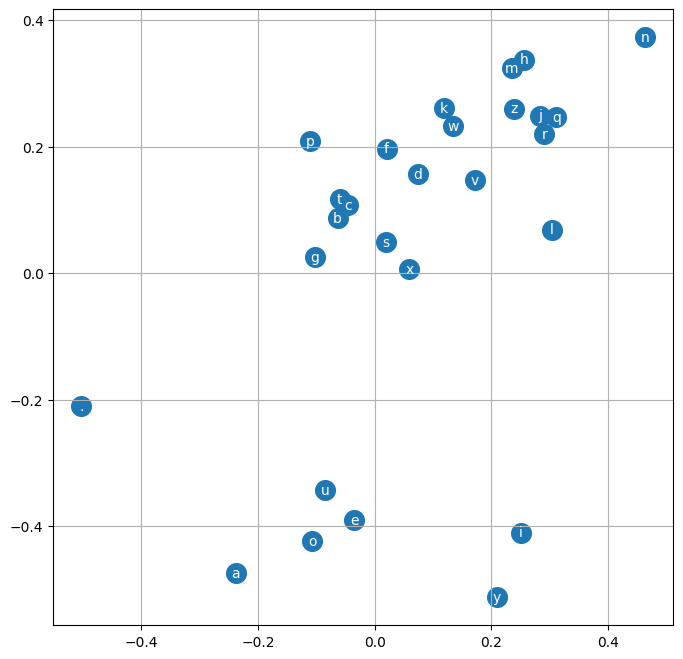

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(mlp.C[:,0].data, mlp.C[:,1].data, s=200)
for i in range(mlp.C.shape[0]):
    plt.text(mlp.C[i,0].item(), mlp.C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Scale up the size of the nn

If we see that the loss on the dev set is close to the loss on the training set => we aren't overfitting, so we can tune the hyperparams.  
This can mean making the layers have more neurons, changing the learning rate, having better learning rate decay, changing the embedding to be larger, having more epochs, chaging the mini-batching size etc.

In [15]:
g = torch.Generator().manual_seed(0)

mlp = MLP(block_size=3, embedding_size=10, hidden_layer_neurons=200, generator=g)
mlp.train(Xtr, Ytr, epochs=200_000, learning_rate=0.1, print_losses=False)

tensor(2.3134, grad_fn=<NllLossBackward0>)

In [16]:
mlp.forward(Xdev, Ydev)

tensor(2.1732, grad_fn=<NllLossBackward0>)

In [17]:
mlp.forward(Xte, Yte)

tensor(2.1823, grad_fn=<NllLossBackward0>)

In [18]:
g = torch.Generator().manual_seed(0)

mlp.generate(count=10, itos=itos, generator=g)

kedleen
nameeya
demonselixhael
rion
safwanush
ziale
kayoce
huthana
aami
chechar
